In [1]:
import pandas as pd
import numpy as np
from utils.funcs import stdP,seP,calcConvRate,checkByZtest,runLinePlotByCats

### Задача:

- 1.Выбрать релевантный тест и определить есть ли статистически значимая разница между:
   - 1.1 уровнем попыток покупки (`transaction_try`)
   - 1.2 уровнем успешных покупок (`transaction_success`)
- 2.Проверить эффект в разрезе операционных систем:
    - 2.2 os == `android`
    - 2.1 os == `ios`
    
- 3.Проверить устойчивость эффекта во времени.
- 4.Подвести итоги (сформулировать выводы)

### считываем датасет и смотрим на структуру данных

In [2]:
df = pd.read_csv('./data/experiment_raw.csv')

In [3]:
df.shape

(27954, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27954 entries, 0 to 27953
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   id                                27954 non-null  int64 
 1   date                              27954 non-null  object
 2   country                           27954 non-null  object
 3   os                                27950 non-null  object
 4   experiment_mobile_checkout_theme  27954 non-null  object
 5   transaction_try                   27954 non-null  int64 
 6   transaction_success               27954 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.5+ MB


#### в датасете всего 27 593 записей, что достаточно мало, поэтому мы не будем делать выборку из генеральной совокупности.

In [5]:
for col in df.columns:
    print(f'col:{col} has {df[col].nunique()} unique values')

col:id has 25743 unique values
col:date has 24 unique values
col:country has 1 unique values
col:os has 2 unique values
col:experiment_mobile_checkout_theme has 2 unique values
col:transaction_try has 2 unique values
col:transaction_success has 2 unique values


#### проверим датасет на пропуски в данных

In [6]:
df.isnull().sum(axis = 0)

id                                  0
date                                0
country                             0
os                                  4
experiment_mobile_checkout_theme    0
transaction_try                     0
transaction_success                 0
dtype: int64

#### есть всего 4 строки в которых тип ОС - пропуск. удалим эти записи

In [7]:
indexes_to_drop = df[df.os.isnull()].index.tolist()
df.drop(indexes_to_drop,inplace=True)

In [8]:
df.isnull().sum(axis = 0)

id                                  0
date                                0
country                             0
os                                  0
experiment_mobile_checkout_theme    0
transaction_try                     0
transaction_success                 0
dtype: int64

In [9]:
df.shape

(27950, 7)

#### Проверим поле "id" на уникальность

In [10]:
df[df.id.duplicated(keep=False)].sort_values('id').head(15)

,id,date,country,os,experiment_mobile_checkout_theme,transaction_try,transaction_success
20326,10171475,2020-04-28,USA,ios,mobile_checkout_theme_new,1,0
20327,10171475,2020-04-28,USA,ios,mobile_checkout_theme_new,1,0
20328,10171475,2020-04-28,USA,ios,mobile_checkout_theme_new,1,0
20331,10171611,2020-04-28,USA,android,mobile_checkout_theme_old,1,0
20332,10171611,2020-04-28,USA,android,mobile_checkout_theme_old,1,0
20333,10171611,2020-04-28,USA,android,mobile_checkout_theme_old,1,0
20352,10188493,2020-04-29,USA,android,mobile_checkout_theme_old,1,0
20350,10188493,2020-04-29,USA,android,mobile_checkout_theme_old,1,0
20351,10188493,2020-04-29,USA,android,mobile_checkout_theme_old,1,0
20357,10188762,2020-04-29,USA,ios,mobile_checkout_theme_old,1,0


#### Есть задвоения по полю id. 

#### Отсюда можно предположить, что это или баг или фича. Вполне может быть такая ситуация, что в рамках id пользователь пытался совершить одно и тоже действие несколько раз в виду системной ошибки приложения. 

#### Если это баг то такие данные необходимо удалить, иначе результат исследования будет искажен. С другой стороны если удалить эти данные целиком мы также можем исказить выводы от эскпиремента, т.к. мы не фиксируем сам факт который все таки был. 

#### Быстрый виуальный анализ показывает, что задвоение происходит по всем 7 полям. Поэтому мы из задвоений по id оставим первую запись, остальные удалим

In [11]:
# аналог row_number() из SQL
df['id_indx'] = df.groupby(df.columns.tolist())['transaction_try'].rank(method='first')

In [12]:
df[df.id==10171475]

,id,date,country,os,experiment_mobile_checkout_theme,transaction_try,transaction_success,id_indx
20326,10171475,2020-04-28,USA,ios,mobile_checkout_theme_new,1,0,1.0
20327,10171475,2020-04-28,USA,ios,mobile_checkout_theme_new,1,0,2.0
20328,10171475,2020-04-28,USA,ios,mobile_checkout_theme_new,1,0,3.0


#### все что с индексом больше 1 удаляем

In [13]:
df = df.drop(df.query("id_indx>1").index)

In [14]:
df.drop('id_indx',axis=1,inplace=True)

In [15]:
df[df.id==10171475]

,id,date,country,os,experiment_mobile_checkout_theme,transaction_try,transaction_success
20326,10171475,2020-04-28,USA,ios,mobile_checkout_theme_new,1,0


#### Добавим новое поле "group" в котром будет 2 значения:
- control - контрольная группа, если experiment_mobile_checkout_theme == "mobile_checkout_theme_old"
- main - основная группа, если experiment_mobile_checkout_theme == "mobile_checkout_theme_new"

In [16]:
df['group'] = np.where(df['experiment_mobile_checkout_theme']== 'mobile_checkout_theme_old', 'control', 'main')

In [17]:
df.head()

,id,date,country,os,experiment_mobile_checkout_theme,transaction_try,transaction_success,group
0,10500155,2020-05-21,USA,android,mobile_checkout_theme_old,0,0,control
1,10500150,2020-05-21,USA,ios,mobile_checkout_theme_new,0,0,main
2,10500139,2020-05-21,USA,android,mobile_checkout_theme_new,0,0,main
3,10500135,2020-05-21,USA,ios,mobile_checkout_theme_new,0,0,main
4,10500134,2020-05-21,USA,android,mobile_checkout_theme_new,0,0,main


### 1 Определим есть ли статистически значимая разница между `transaction_try`  и `transaction_success`

#### для этого разделим датасет на два отдельных датасета:
 -  df_try - целевое действие - `transaction_try`
 -  df_success - целевое действие - `transaction_success`

In [18]:
df_try = df.drop(columns=['transaction_success'],axis=1)
df_success  = df.drop(columns=['transaction_try'],axis=1)

In [19]:
# смотрим на общее распределение по "transaction_try" в разрезе "group"
pd.crosstab(df_try['group'], df_try['transaction_try'],margins=True) 

transaction_try,0,1,All
group,,,
control,10154,2760,12914
main,9932,2911,12843
All,20086,5671,25757


In [20]:
# смотрим на общее распределение по "transaction_try" в разрезе "group"
pd.crosstab(df_success['group'], df_success['transaction_success'],margins=True) 

transaction_success,0,1,All
group,,,
control,11544,1370,12914
main,11270,1573,12843
All,22814,2943,25757


#### 1.1 Проверим есть ли отличия конверсий в группах по целевому действию `transaction_try (попытка покупки) `

In [21]:
resultsTrxTry = calcConvRate(df_try,'group','transaction_try')

In [22]:
resultsTrxTry

,%conv_rate,stdP,seP,total_cnt,target_cnt
group,,,,,
control,0.21372,0.40993,0.00361,12914.00000,2760.00000
main,0.22666,0.41867,0.00369,12843.00000,2911.00000


#### Т.к. конверсия в основной группе (ОГ)  выше чем в контрольной группе (КГ), проверим является ли эта разница в пользу ОГ статистически значимой

In [23]:
checkByZtest(df_try,'group','transaction_try')

z statistic: -2.5057
p-value: 0.0122
conf-interval 95% for control group: [0.2067, 0.2208]
conf-interval 95% for main group: [0.2194, 0.2339]


#### Вывод 1.1 `transaction_try`:
- конверсия в основной группе отличается от конверсии контрольной на +1,29%
- разница между основной и контрольной группой статистически значима (p-value: 0.0122 и это < 0.05)

#### 1.2 Проверим есть ли отличия конверсий в группах по целевому действию `transaction_success (успешная покупка) `

In [24]:
resultTrxSuccess = calcConvRate(df_success,'group','transaction_success')

In [25]:
resultTrxSuccess

,%conv_rate,stdP,seP,total_cnt,target_cnt
group,,,,,
control,0.10609,0.30795,0.00271,12914.00000,1370.00000
main,0.12248,0.32784,0.00289,12843.00000,1573.00000


In [26]:
checkByZtest(df_success,'group','transaction_success')

z statistic: -4.1349
p-value: 0.0000
conf-interval 95% for control group: [0.1008, 0.1114]
conf-interval 95% for main group: [0.1168, 0.1281]


#### Вывод 1.2 `transaction_success`:
- конверсия в основной группе отличается от конверсии в контрольной на +1.64%
- разница между основной и контрольной группой статистически значима (p-value: 0.0000 и это < 0.05)

### 2 Определим есть ли статистически значимая разница между transaction_try и transaction_success в разрезе ОС

####  отличия конверсий в группах по  `transaction_try -  Android`

In [27]:
# попытки входа андроид
dfTryAndroid = df_try[df_try.os=='android'] 

# конверсия попыток входа андроид
resultsTrxTryAndroid = calcConvRate(dfTryAndroid,'group','transaction_try')

In [28]:
resultsTrxTryAndroid

,%conv_rate,stdP,seP,total_cnt,target_cnt
group,,,,,
control,0.19957,0.39967,0.00498,6444.00000,1286.00000
main,0.20980,0.40717,0.00506,6468.00000,1357.00000


#### статистическая значимость `transaction_try -  Android`

In [29]:
checkByZtest(dfTryAndroid,'group','transaction_try')

z statistic: -1.4415
p-value: 0.1495
conf-interval 95% for control group: [0.1898, 0.2093]
conf-interval 95% for main group: [0.1999, 0.2197]


####  отличия конверсий в группах по  `transaction_try -  ios`

In [30]:
# попытка входа ios
dfTryIOS = df_try[df_try.os=='ios'] # попытка входа ios

# конверсия попытка входа ios
resultsTrxTryIOS = calcConvRate(dfTryIOS,'group','transaction_try')

In [31]:
resultsTrxTryIOS

,%conv_rate,stdP,seP,total_cnt,target_cnt
group,,,,,
control,0.22782,0.41943,0.00521,6470.00000,1474.00000
main,0.24376,0.42935,0.00538,6375.00000,1554.00000


#### статистическая значимость `transaction_try -  ios`

In [32]:
checkByZtest(dfTryIOS,'group','transaction_try')

z statistic: -2.1286
p-value: 0.0333
conf-interval 95% for control group: [0.2176, 0.2380]
conf-interval 95% for main group: [0.2332, 0.2543]


#### Вывод 2.1. :
- transaction_try:
    - android: конверсия в ОГ > КГ на +1,02% и это статистически незначимое отличие (p-value: 0.1495 и это > 0.05)
    - ios:конверсия в ОГ > КГ на +1,59% и это статистически значимое отличие (p-value: 0.0333 и это < 0.05)

####  отличия конверсий в группах по  `transaction_success -  Android`

In [33]:
# успешная транзакция андроид
dfTrxAndroid = df_success[df_success.os=='android'] # попытка входа ios

# конверсия 
resultsTrxAndroid = calcConvRate(dfTrxAndroid,'group','transaction_success')

In [34]:
resultsTrxAndroid

,%conv_rate,stdP,seP,total_cnt,target_cnt
group,,,,,
control,0.08783,0.28305,0.00353,6444.00000,566.00000
main,0.10250,0.30331,0.00377,6468.00000,663.00000


#### статистическая значимость `transaction_success -  android`

In [35]:
checkByZtest(dfTrxAndroid,'group','transaction_success')

z statistic: -2.8403
p-value: 0.0045
conf-interval 95% for control group: [0.0809, 0.0947]
conf-interval 95% for main group: [0.0951, 0.1099]


####  отличия конверсий в группах по  `transaction_success -  ios`

In [36]:
# успешная транзакция андроид
dfTrxIOS = df_success[df_success.os=='ios'] # попытка входа ios

# конверсия
resultsTrxIOS = calcConvRate(dfTrxIOS,'group','transaction_success')

In [37]:
resultsTrxIOS

,%conv_rate,stdP,seP,total_cnt,target_cnt
group,,,,,
control,0.12427,0.32988,0.00410,6470.00000,804.00000
main,0.14275,0.34981,0.00438,6375.00000,910.00000


#### статистическая значимость `transaction_success -  ios`

In [38]:
checkByZtest(dfTrxIOS,'group','transaction_success')

z statistic: -3.0794
p-value: 0.0021
conf-interval 95% for control group: [0.1162, 0.1323]
conf-interval 95% for main group: [0.1342, 0.1513]


#### Вывод 2.2 :
- transaction_success:
    - android: конверсия в ОГ > КГ на +1,47% и это статистически значимое отличие (p-value: 0.0045 и это < 0.05)
    - ios:конверсия в ОГ > КГ на +1,85% и это статистически значимое отличие (p-value: 0.0021 и это < 0.05)

### Проверим устойчивость эффекта во времени.

In [39]:
# делаем группировку по дате - ос - группе чтобы посчитать % конверсии в целевое состояние
ndf = df.groupby(['date','os','group'],as_index=False).agg({     
     'id':'count'
    ,'transaction_try':'sum'
    ,'transaction_success':'sum'
})

In [40]:
# считаем % конверсии где целевое состояние - transaction_try
ndf['trxTry%'] = np.round( (ndf['transaction_try'] / ndf['id']),decimals=3)

# считаем % конверсии где целевое состояние - transaction_success
ndf['trxSuccess%'] = np.round( ndf['transaction_success'] / ndf['id'],decimals=3)

# переименовываем поле
ndf.rename(columns=({
    'id':'totalCnt'
}),inplace=True)

In [41]:
ndf['date'] = pd.to_datetime(ndf.date)

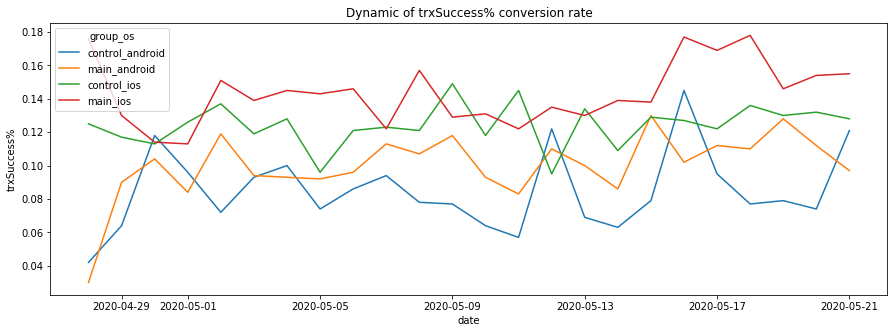

In [42]:
runLinePlotByCats(ndf, ['group','os'],'trxSuccess%')

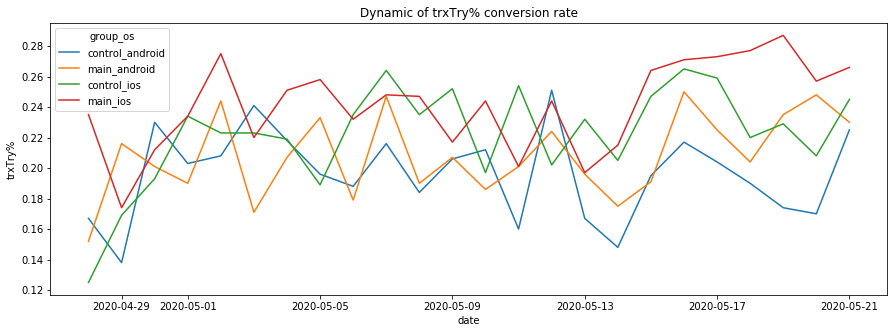

In [43]:
runLinePlotByCats(ndf, ['group','os'],'trxTry%')

#### Вывод 1:
- `transaction_try`:
    - конверсия в основной группе отличается от конверсии контрольной на +1,29%
    - разница между основной и контрольной группой статистически значима (p-value: 0.0122 и это < 0.05)
- `transaction_success`:
    - конверсия в основной группе отличается от конверсии в контрольной на +1.64%
    - разница между основной и контрольной группой статистически значима (p-value: 0.0000 и это < 0.05)

#### Вывод 2:
- `transaction_try`:
    - `android`: конверсия в ОГ > КГ на +1,02%, статистически незначимое отличие (p-value: 0.1495 и это > 0.05)
    - `ios`:конверсия в ОГ > КГ на +1,59% и это статистически значимое отличие (p-value: 0.0333 и это < 0.05)

- `transaction_success`:
    - `android`: конверсия в ОГ > КГ на +1,47%, статистически значимое отличие (p-value: 0.0045 и это < 0.05)
    - `ios`:конверсия в ОГ > КГ на +1,85%, статистически значимое отличие (p-value: 0.0021 и это < 0.05)

#### Вывод 3:
- `transaction_success`:
    - на графике видно, что кривая ОГ почти всегда выше своих соперников как для android так и для ios.
    Поэтому вывод о положительном отличии ОГ против КГ можно легко интерпретировать
    
- `transaction_try`:
    - на данном же графике информация читается сложнее, и визуально сложно определитб какая группа лучше.
    Для это и проводят статистические тесты.
